# Tuning with TPE

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold

## Reading

In [2]:
train_df = pd.read_csv('/home/purp/Desktop/DAA_25/x_train_cleaned.csv')
test_df = pd.read_csv('/home/purp/Desktop/DAA_25/test_cleaned.csv')
x_train = train_df.drop(columns=['Transition'])

print(f"Shape of train_df: {train_df.shape}")
print(f"Shape of test_df: {test_df.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/purp/Desktop/DAA_25/x_train_cleaned.csv'

<Axes: xlabel='Transition'>

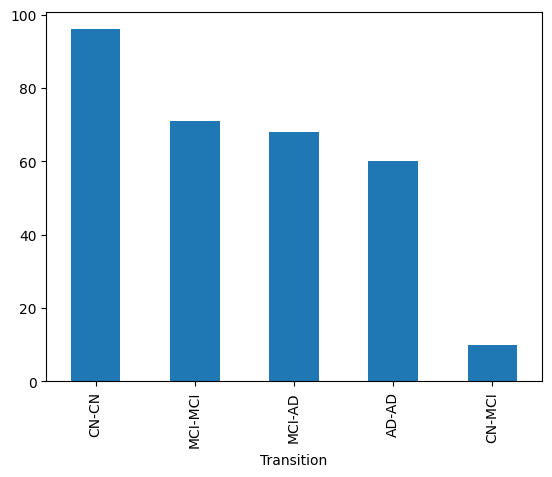

In [ ]:
train_df['Transition'].value_counts().plot(kind='bar')

## Preprocessing

In [ ]:
# Category to numerical
value_map = {
    0: 'CN-CN', 
    1: 'AD-AD', 
    2: 'CN-MCI', 
    3: 'MCI-AD', 
    4: 'MCI-MCI',
}

# Invert the dictionary
inverse_value_map = {v: k for k, v in value_map.items()}

# Replace values in 'column_name' based on the dictionary
train_df['Transition'] = train_df['Transition'].map(inverse_value_map)

In [ ]:
train_df['Transition']

0      0
1      0
2      1
3      2
4      0
      ..
300    0
301    0
302    3
303    4
304    0
Name: Transition, Length: 305, dtype: int64

## High-order statistics

### Skewness

In [ ]:
def calculate_skewness(df):
    skew = df.skew()
    skew_pos = skew[skew > 1]
    skew_neg = skew[skew < -1]
    skew_zero = skew[(skew >= -1) & (skew <= 1)]
    print(f"Positive skewness: {len(skew_pos)}")
    print(f"Negative skewness: {len(skew_neg)}")
    print(f"Zero skewness: {len(skew_zero)}")
    return skew_pos, skew_neg, skew_zero

In [ ]:
def treat_skewness(df):
    skew_pos, skew_neg, skew_zero = calculate_skewness(df)
    
    # Apply log transformation to features with positive skewness
    # Adding a small constant to avoid issues with log(0)
    for col in skew_pos.index:
        df[col] = np.log1p(df[col])  # log1p is log(1 + x), helps avoid log(0)
    
    # Apply cube root transformation to features with negative skewness
    for col in skew_neg.index:
        df[col] = np.cbrt(df[col])
    
    return df

### Kurtosis

In [ ]:
def calculate_kurtosis(df):
    kurt = df.kurtosis()
    kurt_pos = kurt[kurt > 1]
    kurt_neg = kurt[kurt < -1]
    kurt_zero = kurt[(kurt >= -1) & (kurt <= 1)]
    print(f"Positive kurtosis: {len(kurt_pos)}")
    print(f"Negative kurtosis: {len(kurt_neg)}")
    print(f"Zero kurtosis: {len(kurt_zero)}")
    return kurt_pos, kurt_neg, kurt_zero

In [ ]:
kurt_pos, kurt_neg, kurt_zero = calculate_kurtosis(x_train)

Positive kurtosis: 806
Negative kurtosis: 79
Zero kurtosis: 1128


/tmp/ipykernel_17916/3624633527.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers['Transition'] = train_df['Transition']


<Axes: xlabel='Transition'>

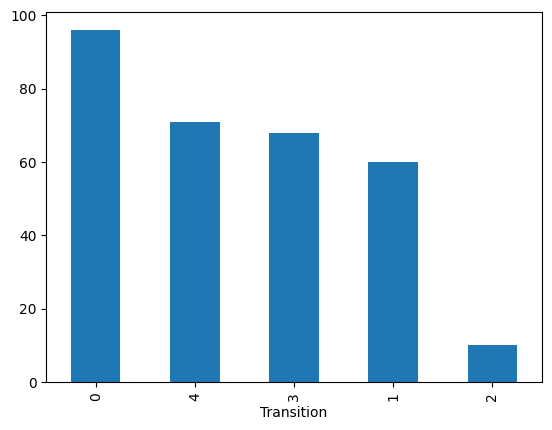

In [ ]:
# This involves handle outliers
# Indetify outliers only with IQR method
Q1 = x_train.quantile(0.25)
Q3 = x_train.quantile(0.75)
IQR = Q3 - Q1
outliers = (x_train < (Q1 - 1.5 * IQR)) | (x_train > (Q3 + 1.5 * IQR))

# Check if the number of outliers for each label class
outliers['Transition'] = train_df['Transition']
outliers = outliers[outliers.any(axis=1)]
outliers['Transition'].value_counts().plot(kind='bar')

### Low variance and high correlated features

In [ ]:
def remove_low_variance_features(data, threshold=0.01):
    # Remove low variance features
    selector = VarianceThreshold(threshold=threshold)
    low_variance_data = selector.fit_transform(data.select_dtypes(include=['float64', 'int64']))

    # Get the columns to keep
    retained_columns = data.select_dtypes(include=['float64', 'int64']).columns[selector.get_support(indices=True)]

    # Create a DataFrame with the retained columns
    data_reduced = pd.DataFrame(low_variance_data, columns=retained_columns)

    return data_reduced

def remove_highly_correlated_features(data, threshold=0.9):
    # Compute the correlation matrix
    corr_matrix = data.corr().abs()

    # Identify columns to remove based on correlation
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] >= threshold:
                to_drop.add(corr_matrix.columns[j])

    # Drop the identified columns
    data_final = data.drop(columns=to_drop)

    return data_final

In [ ]:
x_train = remove_low_variance_features(x_train)
x_train = remove_highly_correlated_features(x_train)

print(f"Shape of x_train after removing low variance and highly correlated features: {x_train.shape}")

x_train = treat_skewness(x_train)

Shape of x_train after removing low variance and highly correlated features: (305, 454)
Positive skewness: 127
Negative skewness: 15
Zero skewness: 312


In [ ]:
x_train

,diagnostics_Image-original_Mean,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterSlice,original_shape_MinorAxisLength,original_shape_SurfaceArea,original_firstorder_10Percentile,...,lbp-3D-k_gldm_DependenceVariance,lbp-3D-k_gldm_LargeDependenceEmphasis,lbp-3D-k_glrlm_RunLengthNonUniformity,lbp-3D-k_glszm_GrayLevelNonUniformity,lbp-3D-k_glszm_LargeAreaEmphasis,lbp-3D-k_glszm_SizeZoneNonUniformity,lbp-3D-k_glszm_SmallAreaHighGrayLevelEmphasis,lbp-3D-k_glszm_ZoneEntropy,Sex,Age
0,5.848123,178.0,7106.0,2.464489,100.964915,72.034714,43.416587,42.409319,4482.023762,3.825862,...,42.528394,357.843231,620.014546,52.142857,361834.964286,14.250000,2.046586,3.021791,0.0,77.1
1,5.238834,190.0,7779.0,2.436448,101.747321,73.246160,44.102154,43.291655,4490.310227,3.825862,...,41.532722,397.771050,503.217558,98.078431,250126.637255,32.313725,2.325829,2.533247,1.0,83.4
2,6.816667,155.0,6707.0,2.732477,105.993915,79.762146,47.853944,47.451935,5412.437400,3.239612,...,40.105892,309.673625,772.901518,72.105263,230564.592105,21.789474,2.201863,2.718587,1.0,81.3
3,6.445162,171.0,8281.0,2.454432,106.797600,78.102497,45.793013,44.737083,4914.650931,3.892996,...,43.256161,395.853037,569.019462,97.079208,286945.039604,30.128713,2.252291,2.603621,1.0,79.6
4,5.568269,150.0,5986.0,2.291037,110.075144,75.432089,43.462628,45.334518,4041.249915,3.914868,...,42.058397,352.020715,527.085222,61.123077,225260.584615,15.184615,1.984241,3.073515,0.0,80.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,6.268191,203.0,7269.0,2.471114,106.890712,77.414469,42.720019,42.935157,4616.626493,3.825862,...,43.839581,369.113633,592.532026,73.103896,279885.961039,23.415584,2.272538,2.747529,1.0,72.2
301,4.846839,181.0,5835.0,2.301199,99.189845,70.349129,45.486262,44.175383,4093.871356,3.870877,...,37.843260,324.308312,583.562995,32.222222,376917.916667,11.333333,2.290788,2.497136,0.0,75.0
302,6.562003,164.0,6905.0,2.505910,105.593223,80.305666,45.099889,46.234417,4724.038667,3.802952,...,41.962920,374.564374,529.342871,64.117647,300979.308824,17.823529,2.054891,2.571710,1.0,79.6
303,7.583210,135.0,7267.0,2.369699,101.608857,74.168727,46.400431,47.094617,4794.646121,3.970618,...,43.618544,382.970001,537.043493,99.077670,216591.330097,30.320388,2.235328,2.688709,0.0,62.4


In [ ]:
# remove rows with any values that are not finite
x_train = x_train[np.isfinite(x_train).all(1)]

In [ ]:
# save column names
train_columns = x_train.columns

In [ ]:
x_train.shape

(305, 454)

### Normalization

In [ ]:
# Apply standard scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

In [ ]:
x_train

array([[ 0.06144132,  0.18675571,  0.36731064, ...,  1.31284555,
        -1.14481704,  0.28940398],
       [-0.93274653,  0.68531579,  0.99919674, ..., -0.57283184,
         0.87350202,  1.23465259],
       [ 1.64183175, -0.7688178 , -0.00731426, ...,  0.14254256,
         0.87350202,  0.91956972],
       ...,
       [ 1.22629265, -0.39489773,  0.17858983, ..., -0.42437257,
         0.87350202,  0.66450264],
       [ 2.89261471, -1.59975128,  0.51847507, ...,  0.02722089,
        -1.14481704, -1.9161761 ],
       [-0.78436272,  0.26984905, -0.030787  , ...,  0.26810599,
        -1.14481704, -0.29574992]])

## Training

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, train_df['Transition'], test_size=0.2, random_state=42, stratify=train_df['Transition'])

### RF

In [ ]:
RandomForest = RandomForestClassifier(n_estimators=100, random_state=42)
RandomForest.fit(x_train, y_train)
y_pred = RandomForest.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.4426229508196721
              precision    recall  f1-score   support

           0       0.48      0.79      0.60        19
           1       0.62      0.67      0.64        12
           2       0.00      0.00      0.00         2
           3       0.27      0.21      0.24        14
           4       0.17      0.07      0.10        14

    accuracy                           0.44        61
   macro avg       0.31      0.35      0.32        61
weighted avg       0.37      0.44      0.39        61



/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

### ET

In [ ]:
ExtraTrees = ExtraTreesClassifier(n_estimators=100, random_state=42)
ExtraTrees.fit(x_train, y_train)
y_pred = ExtraTrees.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Then use CV
scores = cross_val_score(ExtraTrees, x_train, y_train, cv=10, scoring='balanced_accuracy')
print(f"Accuracy: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")
print(scores)

Accuracy: 0.39344262295081966
              precision    recall  f1-score   support

           0       0.45      0.74      0.56        19
           1       0.50      0.50      0.50        12
           2       0.00      0.00      0.00         2
           3       0.22      0.14      0.17        14
           4       0.22      0.14      0.17        14

    accuracy                           0.39        61
   macro avg       0.28      0.30      0.28        61
weighted avg       0.34      0.39      0.35        61



/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Accuracy: 0.346
Standard deviation: 0.07341969250252642
[0.335      0.26333333 0.38333333 0.33666667 0.19904762 0.40595238
 0.38333333 0.38333333 0.3        0.47      ]


### XGB

In [ ]:
xg = GradientBoostingClassifier(n_estimators=100, random_state=42)
xg.fit(x_train, y_train)
y_pred = xg.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.47540983606557374
              precision    recall  f1-score   support

           0       0.54      0.79      0.64        19
           1       0.56      0.42      0.48        12
           2       0.00      0.00      0.00         2
           3       0.36      0.36      0.36        14
           4       0.40      0.29      0.33        14

    accuracy                           0.48        61
   macro avg       0.37      0.37      0.36        61
weighted avg       0.45      0.48      0.45        61



/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

### LGBM

In [ ]:
lgbm = LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced', objective='multiclass')
lgbm.fit(x_train, y_train)
y_pred = lgbm.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35408
[LightGBM] [Info] Number of data points in the train set: 244, number of used features: 453
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [ ]:
# Now with CV
scores = cross_val_score(lgbm, x_train, y_train, cv=10, scoring='balanced_accuracy')
print(f"Accuracy: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")
print(scores)

/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31917
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 453
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

#### GS for ET Classifier

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [False, True]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=ExtraTrees, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
# grid_search.fit(x_train, y_train)

# Print the best parameters and the best score
#print(f"Best parameters found: {grid_search.best_params_}")
#print(f"Best accuracy score: {grid_search.best_score_}")

In [ ]:
# 'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100

# Use the best parameters and CV to evaluate
ExtraTrees = ExtraTreesClassifier(n_estimators=100, max_features='sqrt', max_depth=10, min_samples_split=10, min_samples_leaf=1, bootstrap=True, random_state=42)
ExtraTrees.fit(x_train, y_train)
scores = cross_val_score(ExtraTrees, x_train, y_train, cv=5, scoring='accuracy')
print(f"Accuracy: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")
print(scores)

Accuracy: 0.4670918367346939
Standard deviation: 0.021165784196624016
[0.46938776 0.48979592 0.44897959 0.48979592 0.4375    ]


## Predict in test set

In [ ]:
# proccess test set data
# only keep the columns that are in the training set (nparray)
test_df = test_df[train_columns]
test_df = treat_skewness(test_df)
test_df = scaler.transform(test_df)

Positive skewness: 113
Negative skewness: 14
Zero skewness: 327


In [ ]:
pred =  ExtraTrees.predict(test_df)
pred = pd.DataFrame(pred, columns=['Transition'])
pred.to_csv('/home/purp/Desktop/DAA_25/predictions.csv', index=False)

## TPE

In [ ]:
import optuna

# Função objetivo para otimização
""" 'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [False, True]

}
"""

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)  # Número de árvores
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])  # Número de features
    max_depth = trial.suggest_int('max_depth', 5, 20)  # Profundidade máxima
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Min amostras para split
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)  # Min amostras em folha
    bootstrap = trial.suggest_categorical('bootstrap', [False, True])  # Bootstrap
    
    # Criação do modelo com os hiperparâmetros sugeridos
    model1 = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        bootstrap=bootstrap
    )

    model2 = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
    
    # Avaliação do modelo usando cross-validation
    scores = cross_val_score(model1, x_train, y_train, cv=5, scoring='accuracy')
    accuracy = scores.mean()
    
    return accuracy  # Maximizar a acurácia

# Criação do estudo utilizando TPE como método de amostragem
# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
# study.optimize(objective, n_trials=100)  # número de iterações (trials)

# Resultado
# print(f"Melhor acurácia: {study.best_value}")
# print(f"Melhores hiperparâmetros: {study.best_params}")


/home/purp/anaconda3/envs/omnia_flask/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# best_et = 'n_estimators': 108, 'max_features': 'sqrt', 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4

Accuracy: 0.34780895383908295
Standard deviation: 0.03772476417032968
[0.3171736  0.38449883 0.30236264 0.39904762 0.33596208]


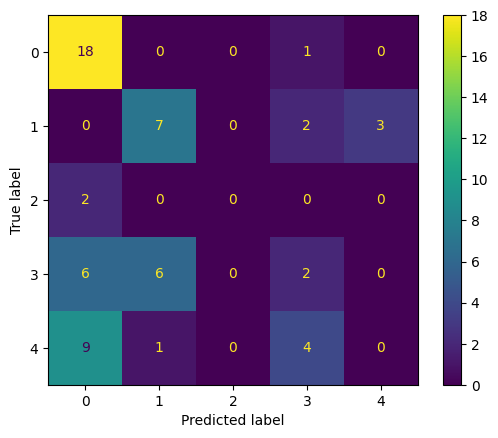

In [ ]:
# Predict with the best parameters
ExtraTrees = ExtraTreesClassifier(n_estimators=225, max_features='sqrt', max_depth=18, min_samples_split=5, min_samples_leaf=4, bootstrap=True, random_state=42)
ExtraTrees.fit(x_train, y_train)
scores = cross_val_score(ExtraTrees, x_train, y_train, cv=5, scoring='f1_macro')
print(f"Accuracy: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")
print(scores)

# check cm 
y_pred = ExtraTrees.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ExtraTrees.classes_)
disp.plot()

# Predict in test set
pred =  ExtraTrees.predict(test_df)

In [ ]:
et_predicts_df = pd.DataFrame(pred, columns=['Result'])
et_predicts_df['Result'] = et_predicts_df['Result'].map(value_map)
et_predicts_df.index = range(1, len(et_predicts_df) + 1)
et_predicts_df.index.name = 'RowId'
et_predicts_df.to_csv('previsoes_et.csv', index=True)
   